<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BASE IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import pickle
import time

In [3]:
#NLTK
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('popular')

# Word Cloud
from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!

In [5]:
# KERAS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding

# SCIKIT LEARN 
from sklearn.feature_extraction import text 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [8]:
#Read Data

# CODE FOR READING DATA FROM DOODLE DRIVE IN COLLAB  
'''
from google.colab import drive
drive.mount('/content/drive/')
!pwd
!ls
categories = ['business','entertainment','politics','sport','tech']
df = pd.read_csv('dataset/bbc-text.csv').rename(columns={'sms':'text'})
df.head()
'''
# CODE FOR READING DATA FROM LOCAL DRIVE
categories = ['business','entertainment','politics','sport','tech']
df = pd.read_csv('dataset/bbc-text.csv').rename(columns={'sms':'text'})
df.head()


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


tech


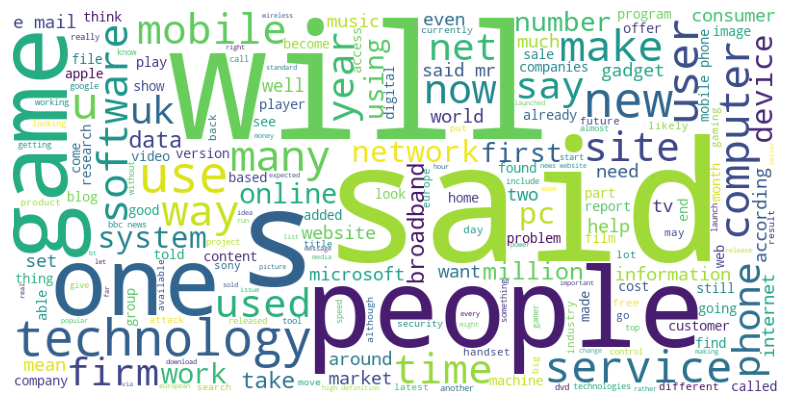

business


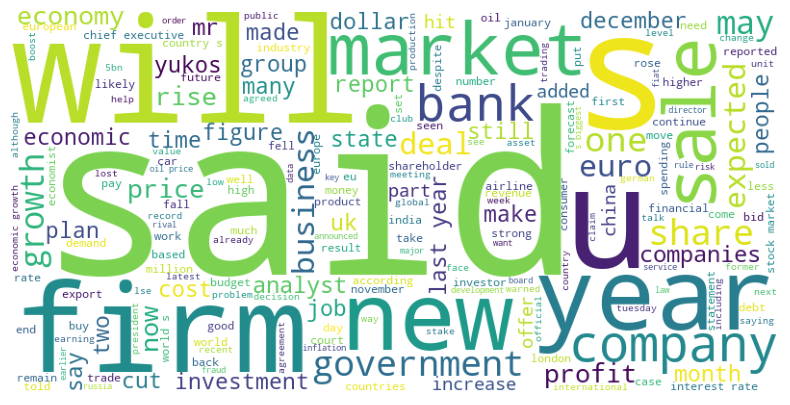

sport


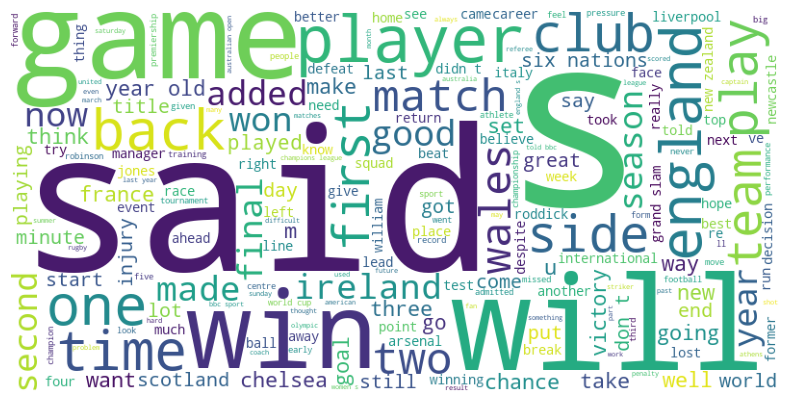

entertainment


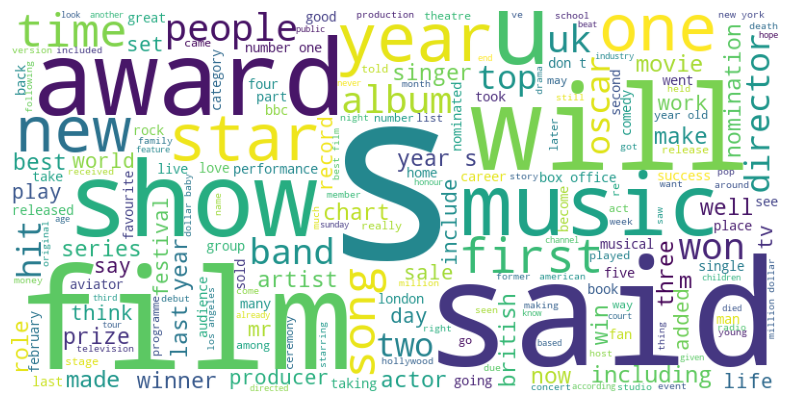

politics


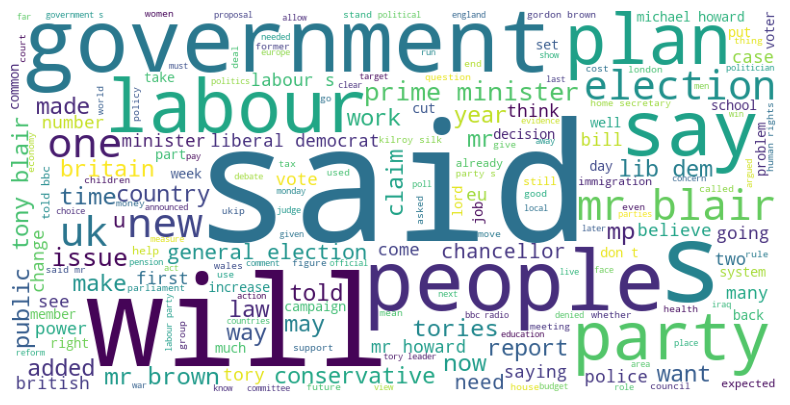

ALL Categories:


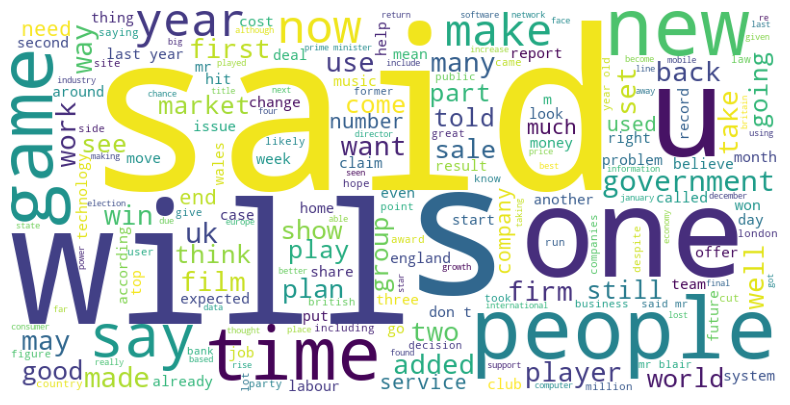

In [9]:

#WordCloud
cat = df['category'].unique()

for i in range(0,len(cat)):
    words = ' '.join(df.loc[df['category']==cat[i], 'text'])

    wordcloud = WordCloud( 
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=800,
                          height=400
                ).generate(words)
    print(cat[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

words = ' '.join(df.loc[:, 'text'])

wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Label Encoder
#### Use inverse_transform at the end after predicting

In [10]:
y = df['category']
X = df.drop(['category'],axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 828        sport
537         tech
1586        tech
1121        tech
1849    politics
Name: category, dtype: object ...
after: [3 4 4 ... 1 0 2] ...


In [11]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(5)]))

[408 309 333 409 321]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
['business' 'entertainment' 'politics' 'sport' 'tech']


## Preprocess Data - (split by \n, remove periods, remove slashes)

In [12]:
#Parameters for hyperparameter  tuning
dropout = 0.4
EMBEDDING_DIM = 50
traina = True #embeedding layer trainable

In [13]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [14]:
#Preprocess both train and test separately
X_train['text'] = preprocess(X_train['text'])
X_test['text'] = preprocess(X_test['text'])

In [15]:
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [16]:
X_test['text']

0      [u, eu, tariff, chaos, trade, row, u, asked, w...
1      [howard, reject, bnp, claim, tory, leader, mic...
2      [fantasy, book, win, hollywood, deal, british,...
3      [fightstar, take, stage, charlie, simpson, too...
4      [former, ni, minister, scott, dy, former, nort...
                             ...                        
440    [troubled, marsh, sec, scrutiny, u, stock, mar...
441    [baghdad, blogger, big, screen, film, based, i...
442    [talk, held, gibraltar, future, two, day, talk...
443    [u, rule, yukos, refuge, call, yukos, said, u,...
444    [howard, attack, pay, later, budget, tory, lea...
Name: text, Length: 445, dtype: object

In [17]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [19]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('./models/glove.6B.50d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

/home/anshu/anaconda3/envs/nlp/lib/python3.7/site-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 27657 unique tokens.
Shape of data tensor: (1780, 1000)
Shape of label tensor: (1780, 5)


In [21]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [22]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=traina)

In [23]:
#Map label name to its index
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

In [24]:
model_name = "CNN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+str(traina)+'final'
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_cnn = TensorBoard(log_dir='./Graph_CNN', histogram_freq=0,write_graph=True, write_images=True)

2024-04-24 15:42:45.658930: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-24 15:42:45.659006: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-24 15:42:45.661005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-24 15:42:45.693450: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-04-24 15:42:45.693753: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcupti.so.11.0'; dlerror: libcupti.so.11.0: cannot open shared object file: No such file or directory
2024-04-24 15:42:45.694483: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so
2024-04-24 15:42:45.696912: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-24 15:42:45.697054: I tensorflow/c

In [25]:
np.random.seed(123)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(dropout,seed=123)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(dropout,seed=123)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(dropout,seed=123)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

2024-04-24 15:42:56.632426: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-24 15:42:56.634118: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 15:42:56.634174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 960 computeCapability: 5.2
coreClock: 1.291GHz coreCount: 8 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.46GiB/s
2024-04-24 15:42:56.634442: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-24 15:42:56.634564: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library

In [26]:
np.random.seed(123)
stmillis = int(round(time.time() * 1000))
history = model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping,tensorboard_cnn],shuffle=False)
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

2024-04-24 15:43:02.000072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-24 15:43:02.000745: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3599995000 Hz


Epoch 1/50


2024-04-24 15:43:02.981154: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 65273856 exceeds 10% of free system memory.
2024-04-24 15:43:03.184716: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 65273856 exceeds 10% of free system memory.


 1/12 [=>............................] - ETA: 15s - loss: 2.2262 - acc: 0.2031

2024-04-24 15:43:03.447699: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-24 15:43:03.447746: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-24 15:43:03.465372: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 65273856 exceeds 10% of free system memory.
2024-04-24 15:43:03.669721: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 65273856 exceeds 10% of free system memory.


 2/12 [====>.........................] - ETA: 4s - loss: 2.6473 - acc: 0.1973 

2024-04-24 15:43:03.915479: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-24 15:43:03.915615: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2024-04-24 15:43:04.016844: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-04-24 15:43:04.017922: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-24 15:43:04.020792: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./Graph_CNN/train/plugins/profile/2024_04_24_15_43_04
2024-04-24 15:43:04.021773: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./Graph_CNN/train/plugins/profile/2024_04_24_15_43_04/DESKTOP-M0A6HS0.trace.json.gz
2024-04-24 15:43:04.024746: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./G

12/12 [==============================] - 6s 431ms/step - loss: 2.1470 - acc: 0.2700 - val_loss: 1.2164 - val_acc: 0.7556

Epoch 00001: val_loss improved from inf to 1.21640, saving model to CNN-0.4-50-Trainable-Truefinal_weights.01-1.22.hdf5
Epoch 2/50
12/12 [==============================] - 5s 389ms/step - loss: 1.0591 - acc: 0.5759 - val_loss: 0.5766 - val_acc: 0.9382

Epoch 00002: val_loss improved from 1.21640 to 0.57657, saving model to CNN-0.4-50-Trainable-Truefinal_weights.02-0.58.hdf5
Epoch 3/50
12/12 [==============================] - 5s 405ms/step - loss: 0.4918 - acc: 0.8400 - val_loss: 0.4216 - val_acc: 0.8680

Epoch 00003: val_loss improved from 0.57657 to 0.42162, saving model to CNN-0.4-50-Trainable-Truefinal_weights.03-0.42.hdf5
Epoch 4/50
12/12 [==============================] - 6s 447ms/step - loss: 0.4287 - acc: 0.8386 - val_loss: 0.3292 - val_acc: 0.8792

Epoch 00004: val_loss improved from 0.42162 to 0.32916, saving model to CNN-0.4-50-Trainable-Truefinal_weights.

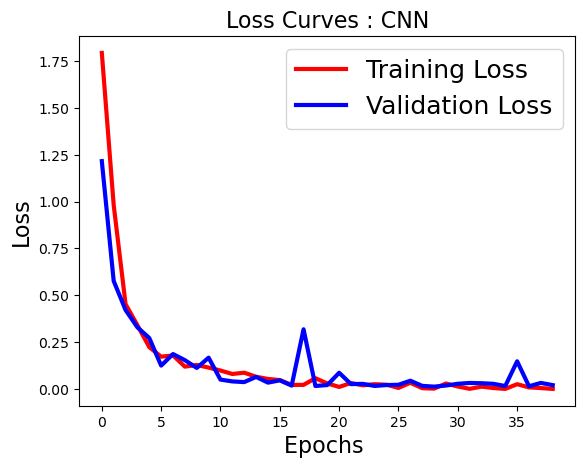

In [27]:
fig=plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves : CNN',fontsize=16)
fig.savefig(model_name+'.png')
plt.show()

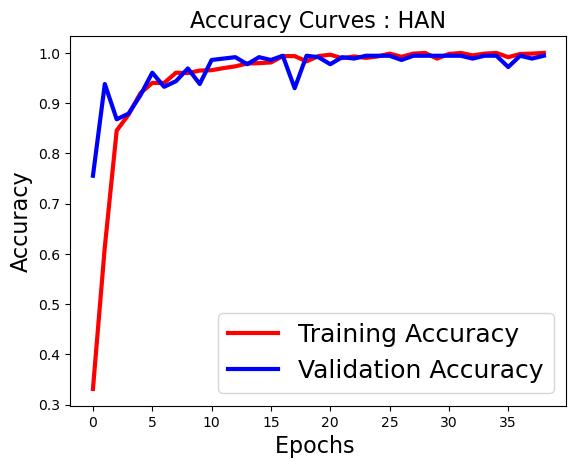

In [28]:
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig.savefig(model_name+'-ACC'+'.png')
plt.show()

In [29]:
# Save the trained weights
model.save("./models/"+model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open("./models/"+model_name + ".json", "w") as json_file:
    json_file.write(model_json)

## Predict on Test Data

In [31]:
from tensorflow.keras.models import model_from_json

json_file = open("./models/CNN-0.4-50-Trainable-Truefinal.json", "r")
loaded_model_json = json_file.read()
json_file.close()
best_model = model_from_json(loaded_model_json)

best_model.load_weights("./models/CNN-0.4-50-Trainable-Truefinal.h5")

best_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [32]:
def find_test_acc(prediction):
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")

In [33]:
def predict_test(model):
  #Tokenize test data and apply model prediction
  sequences = tokenizer.texts_to_sequences(test_text)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)
  prediction = model.predict(data)
  find_test_acc(prediction)

In [35]:
predict_test(best_model)

Shape of data tensor: (445, 1000)
Shape of label tensor: (1780, 5)


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/anshu/anaconda3/envs/nlp/lib/python3.7/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/anshu/anaconda3/envs/nlp/lib/python3.7/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2098, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 